In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

from jtb_2022_code.utils.figure_common import *
from jtb_2022_code import FigureSingleCellData

/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2023-02-24 16:27:43 2 Preprocessing methods selected: Predictor method zscore [limit 10] Response method zscore [limit 10] Pre-TFA expression method robustscaler [limit 20] 


In [3]:
data = FigureSingleCellData()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [4]:
import scanpy as sc
import anndata as ad
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

_expt2_idx = data.all_data.obs['Experiment'] == 2
_edists = squareform(pairwise_distances(data.all_data.X[_expt2_idx, :].T.A, metric="euclidean"), checks=False)

In [5]:
import sys
sys.setrecursionlimit(10000)

_ami_idx = np.array(
    dendrogram(
        linkage(
            _edists, 
            metric='correlation'), 
        no_plot=True
    )['leaves']
)

_expt2_idx = data.all_data.obs['Experiment'] == 2
expt2 = ad.AnnData(
    data.all_data.X[_expt2_idx, :][:, _ami_idx],
    dtype=np.float64
)
expt2.obs_names = data.all_data.obs_names[_expt2_idx]
expt2.obs = data.all_data.obs.loc[_expt2_idx, :]
expt2.var_names = data.all_data.var_names[_ami_idx]

expt2.layers['14PC'] = data.all_data.obsm['X_pca'][_expt2_idx, 0:14] @ data.all_data.varm['PCs'][:, 0:14].T
expt2.layers['14PC'] = expt2.layers['14PC'][:, _ami_idx]

expt2

AnnData object with n_obs × n_vars = 104881 × 5747
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'program_0_time', 'program_1_time'
    layers: '14PC'

/home/cj59/.local/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


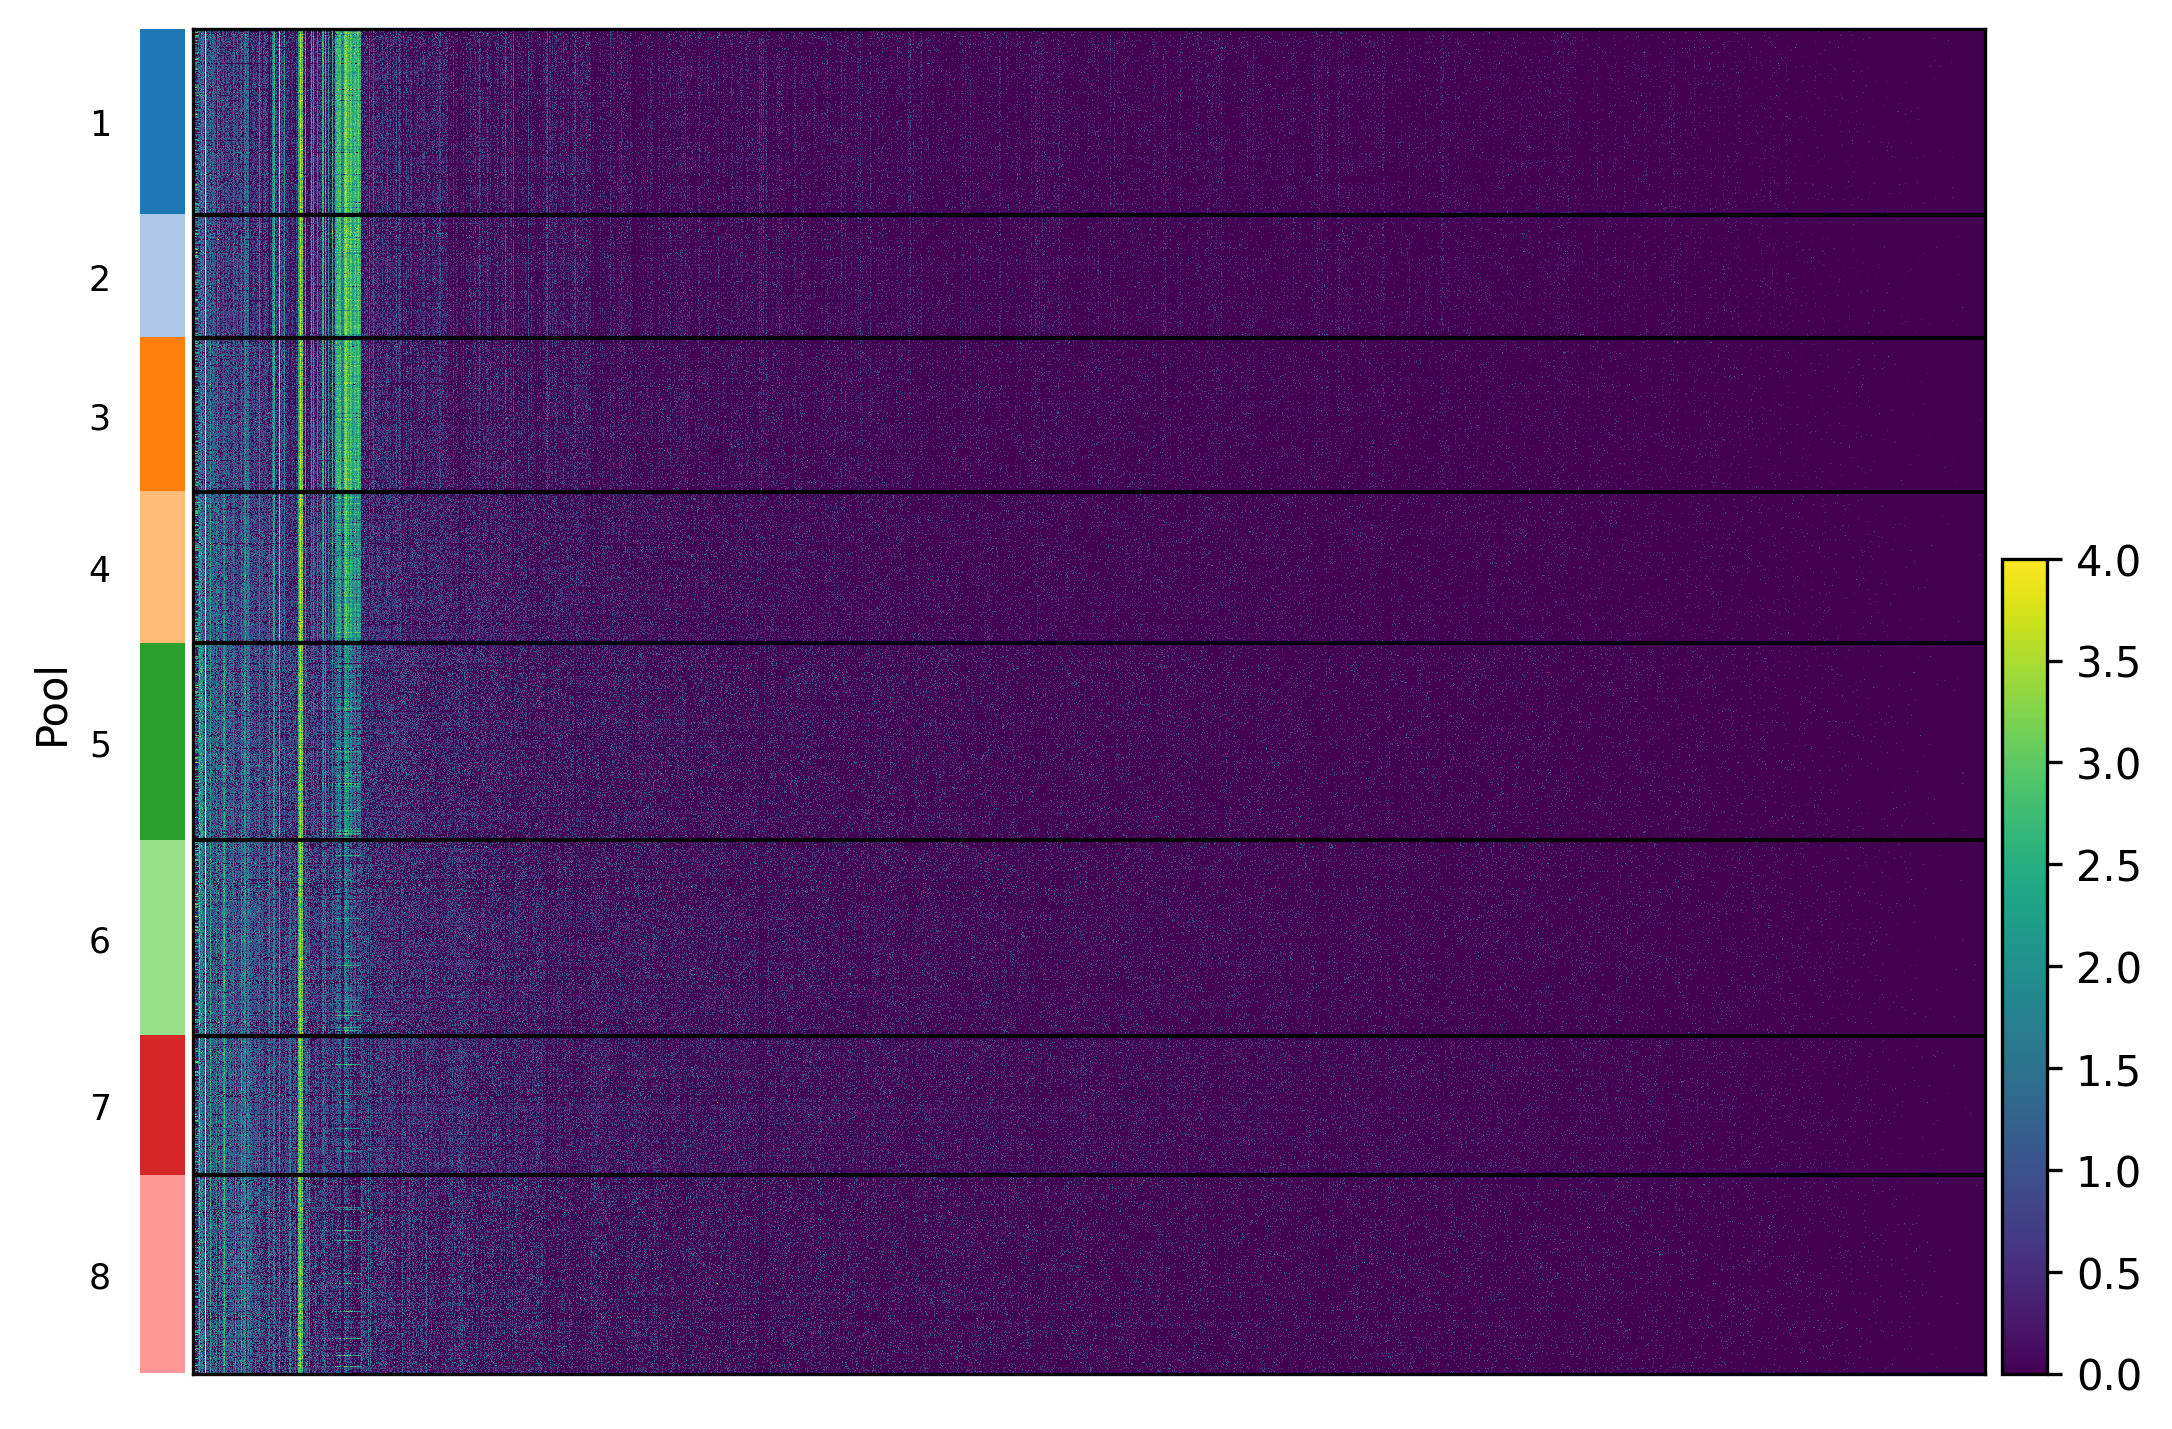

In [8]:
plt.rcParams["figure.dpi"] = 300
sc.pl.heatmap(expt2, expt2.var_names, ['Pool'], vmin=0, vmax=4, save="_expt2.png")

In [ ]:
fig

/home/cj59/.local/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


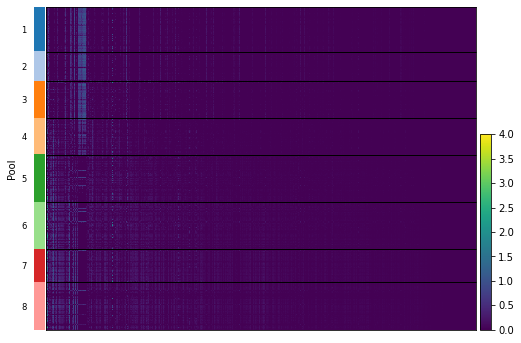

In [39]:
sc.pl.heatmap(expt2, expt2.var_names, ['Pool'], layer='14PC', vmin=0, vmax=4, save="_expt2_pc_denoise.png")

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA().fit(expt2.X)

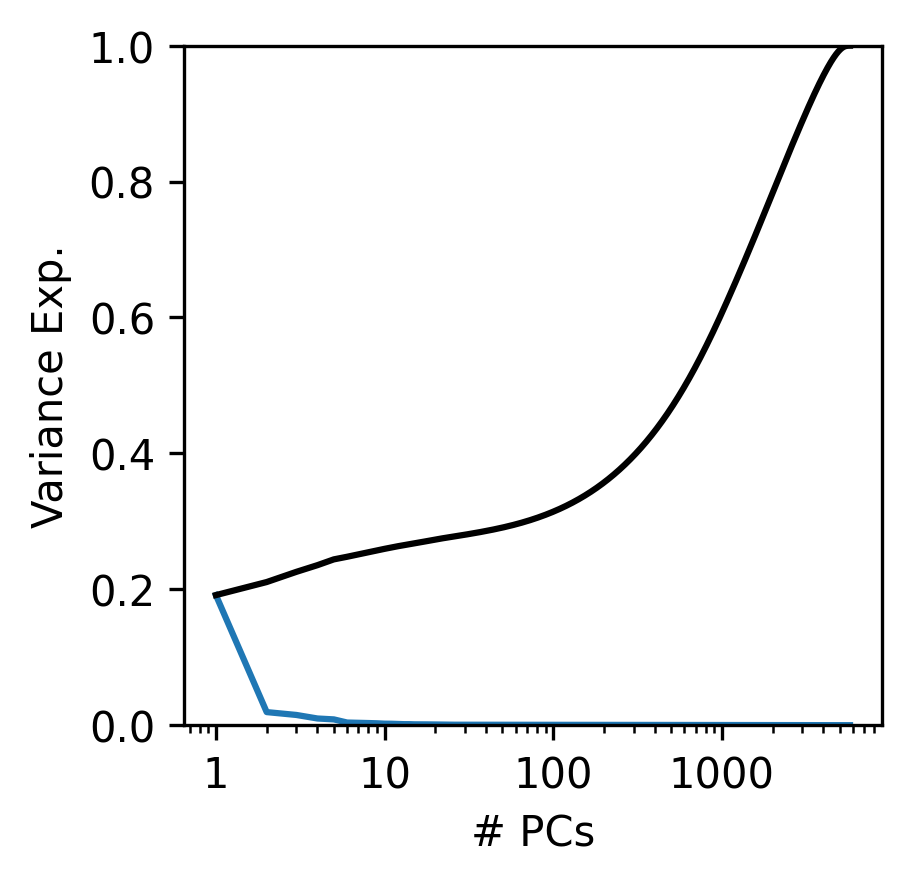

In [78]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)

ax.plot(
    np.arange(pca.explained_variance_ratio_.shape[0]) + 1,
    pca.explained_variance_ratio_
)

ax.plot(
    np.arange(pca.explained_variance_ratio_.shape[0]) + 1,
    np.cumsum(pca.explained_variance_ratio_),
    c='black'
)


ax.set_xscale('log')
ax.set_ylabel('Variance Exp.')
ax.set_xlabel('# PCs')
ax.set_ylim(0, 1)
ax.xaxis.set_major_formatter(ScalarFormatter())

In [72]:
np.insert(pca.explained_variance_ratio_, 0, 0)

array([0.00000000e+00, 1.91397287e-01, 1.92336852e-02, ...,
       4.72330376e-08, 3.82830853e-08, 2.05600885e-08])

In [79]:
pca2 = PCA().fit_transform(expt2.layers['14PC'])

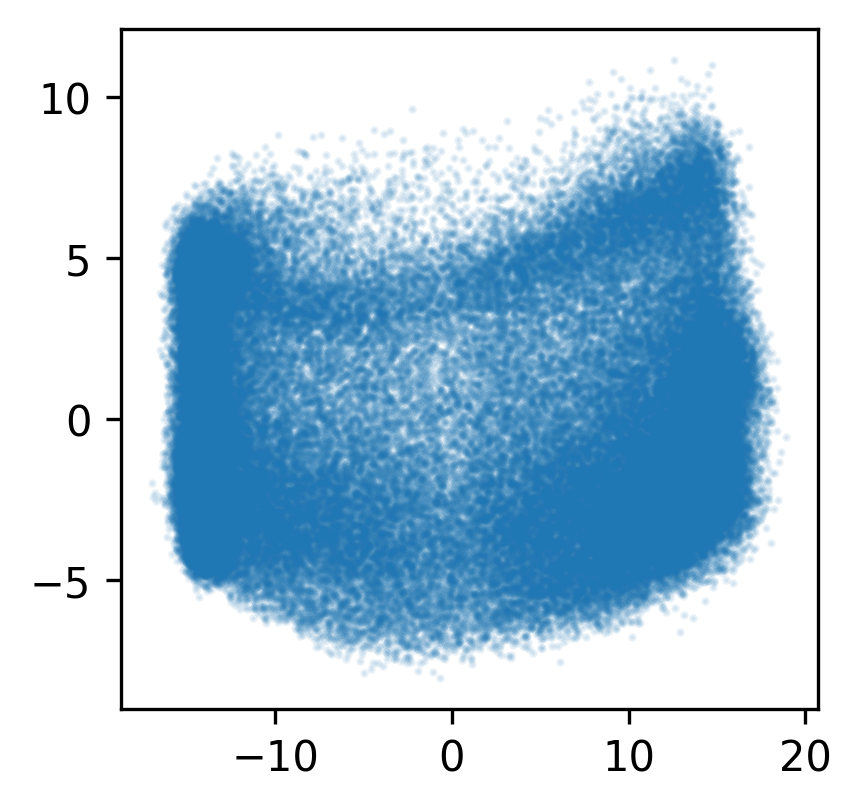

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)

ax.scatter(
    pca2[:, 0],
    pca2[:, 1],
    alpha=0.1,
    s=1
)

